In [1]:
#지도학습: sample, 정답 있는 경우
#비지도학습: 생성형 모델 genrative ai -- gan (generative adversarial network)
#https://taehojo.github.io/deeplearning-for-everyone/gan.html#3-%EC%A0%81%EB%8C%80%EC%A0%81-%EC%8B%A0%EA%B2%BD%EB%A7%9D-%EC%8B%A4%ED%96%89%ED%95%98%EA%B8%B0
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

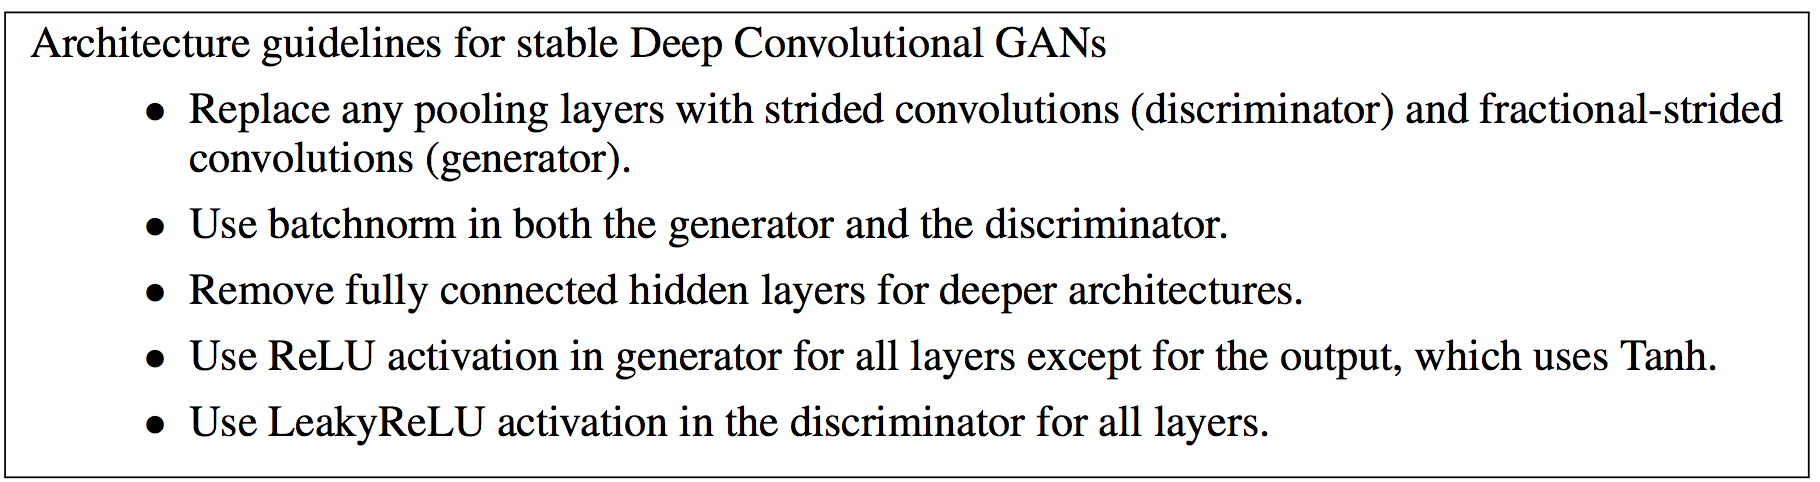

In [4]:
# 생성자 모델을 만듭니다.
generator = models.Sequential()
generator.add(layers.Dense(7*7*128, input_dim=100, activation=layers.LeakyReLU(0.2))) #alpha= 0.2
generator.add(layers.BatchNormalization()) #batch 단위 출력의 mean, sd를 계속 구함
#https://eehoeskrap.tistory.com/430
generator.add(layers.Reshape((7, 7, 128)))
generator.add(layers.UpSampling2D()) #width, height *2 -> 면적 *4
generator.add(layers.Conv2D(64, kernel_size=5, padding='same')) #DCGAN #출력 사이즈가 변하지 않게 자동 padding
generator.add(layers.BatchNormalization()) #activation 전에 batch normalization
generator.add(layers.Activation(layers.LeakyReLU(0.2)))
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 batch_normalization_4 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_5 (Batc  (None, 14, 14, 64)      

In [6]:
discriminator = models.Sequential()
discriminator.add(layers.Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same")) #shape: 3+ 2k=28, k= 0~13 #conv2d.png
#5*5*1*64+64
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Conv2D(128, kernel_size=5, strides=2, padding="same")) #shape: 3+2k=14 k=0~6
#5*5*64*128+128
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Flatten())
#7*7*128
discriminator.add(layers.Dense(1, activation='sigmoid'))
#6272+1
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False #생성자가 학습할 때 판별자는 이걸로 학습 X
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_5 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_6 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [8]:
ginput=layers.Input(shape=(100,)) #noise 100
dis_output=discriminator(generator(ginput))
gan=models.Model(ginput, dis_output)
# 케라스에서 모델 설계를 할 때 Sequential( )을 주로 사용해왔다. 
# 단순히 이전 layer의 output이 다음 layer의 input으로 들어가는 선형적인 경우에 사용해주면 아주 편리하기 때문이다. 
# 그래서 단점도 존재한다. DenseNet( ) 같이 선형적 흐름이 아닌 모델 설계의 경우엔 사용하질 못 한다.
# keras.models.Model( )을 사용하면 Sequential( )의 불편한 점에서 벗어날 수 있다. 이 놈은 Multi Input / Multi Output을 지원한다.
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_4 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [9]:
import os
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [30]:
(X, _), (_, _) = mnist.load_data()
X = X.reshape(X.shape[0], 28, 28, 1).astype(float)
X

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [59]:
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터를 불러옵니다.

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float)
  X_train = (X_train - 127.5) / 127.5  # 픽셀 값은 0에서 255 사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size) #0~5999 사이에서 batch_size 개수 만큼 랜덤으로 뽑아라
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true) #판별자 학습 -> 손실값 나옴 -> 내부에서 bias, weight param 학습 1회 (진짜 판별 후 발생하는 loss)

          # 가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100)) #(batch_size * 100, 0~1 사이 noise값)
          #(2)에서는 생성자에 집어넣을 가상 이미지를 만듭니다. 정수가 아니기 때문에 np.random.normal()의 함수를 사용했습니다. 
          # 조금 전과 마찬가지로np.random.normal(a, b, c)의 형태를 가지며 a부터 b까지의 실수 중 c개를 랜덤으로 뽑으라는 뜻입니다. 
          # 여기서 c자리에 있는 (batch_size, 100)의 의미는 batch_size만큼 100열을 뽑으라는 뜻입니다.
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) #(가짜 판별 후 발생하는 loss)

          # 판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true) #noise가 진짜라는 가정하에 train, gan 학습, 즉 generator 학습, 손실 (trainable false)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)
        # 이 부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
        # 소스 코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0: #interval 마다
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)
              print(gen_imgs)
              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5) #fig=그래프가 담기게 되는 프레임, ax=그래프가 그려지는 캔버스
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray') #imshow:원하는 크기의 행렬을 만들어서 각 칸을 원하는 색으로 채우는 것
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("./gan_images/gan_mnist_%d.png" % i)

1/1 [==============================] - 0s 38ms/step
epoch:0  d_loss:0.5176  g_loss:1.5739
1/1 [==============================] - 0s 46ms/step
[[[[-0.9999925 ]
   [-1.        ]
   [-1.        ]
   ...
   [-0.9982434 ]
   [-0.99590355]
   [-0.99057144]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ...
   [-0.99986047]
   [-0.9995997 ]
   [-0.9989555 ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ...
   [-0.99994934]
   [-0.99989265]
   [-0.9997244 ]]

  ...

  [[-0.99996537]
   [-1.        ]
   [-1.        ]
   ...
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-0.9997771 ]
   [-0.99999774]
   [-1.        ]
   ...
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-0.9975689 ]
   [-0.9999214 ]
   [-0.9999967 ]
   ...
   [-1.        ]
   [-1.        ]
   [-1.        ]]]


 [[[-0.80744267]
   [-0.9775488 ]
   [-0.9938506 ]
   ...
   [-0.9978704 ]
   [-0.9946551 ]
   [-0.98344165]]

  [[-0.9710781 ]
   [-0.99823785]
   [-0.9996604 ]
   ...
   [-0.9999924

KeyboardInterrupt: 

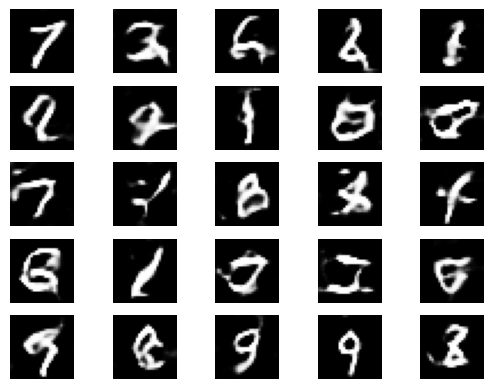

In [60]:
gan_train(2001, 32, 200) #epoch 2001, interval 200, batch 32

In [29]:
#https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#https://comlini8-8.tistory.com/7